In [2]:
import tensorflow as tf

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2 * ((precision_val * recall_val) / (precision_val + recall_val + tf.keras.backend.epsilon()))

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom top layers for your PCG classification task
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy',precision,recall,f1_score])

# Set up data generators for training, validation, and test sets
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided",
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    r"E:\MAIN PROJECT\FILTERD CODES\data splitting\scalogram data\ECG_scalogram_divided",
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

# Fine-tune the model on your PCG data

Found 2782 images belonging to 2 classes.
Found 695 images belonging to 2 classes.


In [12]:
# Define a callback to save the model after each epoch
# checkpoint_callback = ModelCheckpoint(
#     filepath='/content/drive/MyDrive/ECG_PCG_split/VGG16_epochs/ECG_VGG16/VGG16_ECG_epoch_{epoch:02d}.keras',  # Save the model with the epoch number in the filename
#     save_weights_only=False,  # Save the entire model (architecture, weights, and training configuration)
#     save_best_only=False,  # Save the model after each epoch, regardless of performance
#     monitor='val_accuracy',  # Quantity to monitor on the validation set
#     mode='max',  # Mode can be 'min' or 'max' depending on whether you want to minimize or maximize the monitored quantity
#     verbose=1
# )

# Define a callback for early stopping
early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Quantity to monitor on the validation set
    patience=20,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True,  # Restore model weights from the epoch with the best value of the monitored quantity
    verbose=1
)



In [13]:
# Include both callbacks in model training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Adjust the number of epochs as needed
    callbacks=[early_stopping_callback]
) # Adjust the number of epochs based on your needs

Epoch 1/50
44/44 [==============================] - 269s 6s/step - loss: 1.3471 - accuracy: 0.6139 - precision: 0.1818 - recall: 0.1143 - f1_score: 0.1288 - val_loss: 0.6996 - val_accuracy: 0.7108 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00
Epoch 2/50
44/44 [==============================] - 275s 6s/step - loss: 0.6251 - accuracy: 0.7157 - precision: 0.1847 - recall: 0.1213 - f1_score: 0.1243 - val_loss: 0.6522 - val_accuracy: 0.7309 - val_precision: 0.2727 - val_recall: 0.0308 - val_f1_score: 0.0533
Epoch 3/50
44/44 [==============================] - 273s 6s/step - loss: 0.4953 - accuracy: 0.7735 - precision: 0.2955 - recall: 0.1370 - f1_score: 0.1783 - val_loss: 0.4905 - val_accuracy: 0.7266 - val_precision: 0.3636 - val_recall: 0.0752 - val_f1_score: 0.1142
Epoch 4/50
44/44 [==============================] - 273s 6s/step - loss: 0.4892 - accuracy: 0.7674 - precision: 0.2955 - recall: 0.1044 - f1_score: 0.1470 - val_loss: 0.4595 - val_accuracy: 0.7

44/44 [==============================] - 217s 5s/step


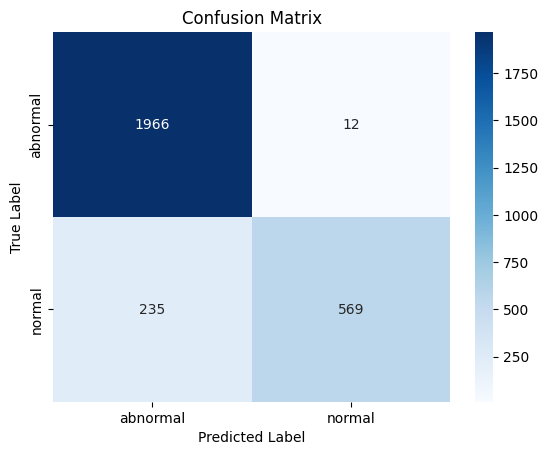

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      1978
           1       0.98      0.71      0.82       804

    accuracy                           0.91      2782
   macro avg       0.94      0.85      0.88      2782
weighted avg       0.92      0.91      0.91      2782



In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_train = train_generator.classes
y_pred_prob_train= model.predict(train_generator)
y_pred_train = np.round(y_pred_prob_train)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_train = confusion_matrix(y_true, y_pred_train)

# Visualize the confusion matrix with values
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_train, y_pred_train))

In [18]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_train[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [0.01331329 0.00960128 0.01565376 ... 0.82681865 0.9833748  0.841821  ]
Probabilities for class 1: [0.9866867  0.9903987  0.9843463  ... 0.17318135 0.01662523 0.15817899]


11/11 [==============================] - 56s 5s/step


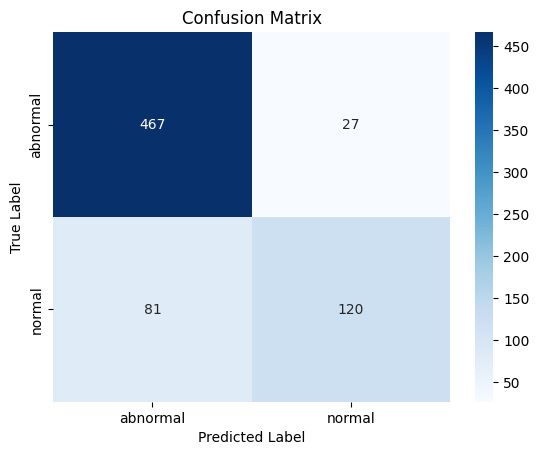

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       494
           1       0.82      0.60      0.69       201

    accuracy                           0.84       695
   macro avg       0.83      0.77      0.79       695
weighted avg       0.84      0.84      0.84       695



In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have a trained model named 'model' and validation generator 'val_generator'

# Predict the labels on the validation set
y_true_val = val_generator.classes
y_pred_prob_val = model.predict(val_generator)
y_pred_val = np.round(y_pred_prob_val)  # Convert probabilities to binary predictions

# Calculate the confusion matrix
cm_val = confusion_matrix(y_true_val, y_pred_val)

# Visualize the confusion matrix with values
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['abnormal', 'normal'], yticklabels=['abnormal', 'normal'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_true_val, y_pred_val))

In [33]:
print(cm_train,cm_val)

[[1966   12]
 [ 235  569]] [[467  27]
 [ 81 120]]


In [20]:
# Assuming the classes are labeled as 0 and 1
class_0_probabilities = y_pred_prob_val[:, 0]  # Probabilities for class 0
class_1_probabilities = 1 - class_0_probabilities  # Probabilities for class 1

# Print the probabilities for both classes
print("Probabilities for class 0:", class_0_probabilities)
print("Probabilities for class 1:", class_1_probabilities)

Probabilities for class 0: [3.55539434e-02 3.15743536e-02 2.95053814e-02 2.72234846e-02
 3.31469662e-02 2.96408646e-02 3.57980207e-02 3.23749371e-02
 3.20400260e-02 3.13123405e-01 3.24117452e-01 3.51732790e-01
 3.92925769e-01 4.63780761e-01 3.85735810e-01 3.50092398e-03
 3.02360323e-03 3.29035427e-03 4.67322674e-03 3.77085898e-03
 2.98353797e-03 2.83427443e-03 2.81644566e-03 4.18063700e-02
 4.40056175e-02 4.16067019e-02 4.69041727e-02 4.53355871e-02
 2.88353059e-02 4.24745530e-02 4.18855287e-02 4.37665209e-02
 5.62098883e-02 3.32500152e-02 1.12478115e-01 1.09000519e-01
 8.01509172e-02 2.54413635e-01 4.24594283e-01 2.77112812e-01
 5.70093282e-02 1.54395744e-01 2.59818166e-01 4.25846756e-01
 7.48910785e-01 2.80191064e-01 7.70958543e-01 2.01759934e-02
 2.16929138e-01 1.51961688e-02 2.00533960e-02 2.77715363e-02
 2.74975896e-02 2.90251933e-02 1.33874761e-02 2.09182780e-02
 4.73842286e-02 6.10689893e-02 8.82283598e-02 7.49203488e-02
 5.99452369e-02 2.36166120e-02 5.15329093e-02 3.62220444e-

In [5]:
import re

# Open the text document in read mode
with open(r"E:\MAIN PROJECT\FILTERD CODES\data splitting\trained models\VGG16\VGG16_ECG\VGG16_ECG.txt", 'r') as file:
    # Read the entire contents of the file
    text = file.read()

# Regular expression pattern to match accuracy values
pattern1 = r"accuracy: (\d+\.\d+)"
pattern2 = r"val_accuracy: (\d+\.\d+)"
pattern3 = r"loss: (\d+\.\d+)"
pattern4 = r"val_loss: (\d+\.\d+)"


# Find all accuracy values using regex
train_accuracy1 = re.findall(pattern1, text)
val_accuracy = re.findall(pattern2, text)
train_loss1 = re.findall(pattern3, text)
val_loss = re.findall(pattern4, text)

# Convert accuracy values to float
train_accuracy1 = [float(value) for value in train_accuracy1]
val_accuracy = [float(value) for value in val_accuracy]
train_loss1 = [float(value) for value in train_loss1]
val_loss = [float(value) for value in val_loss]



In [6]:
train_accuracy=[]
train_loss=[]
i=-2
while i<97:
    train_accuracy.append(train_accuracy1[i+2])
    train_loss.append(train_loss1[i+2])
    i+=2


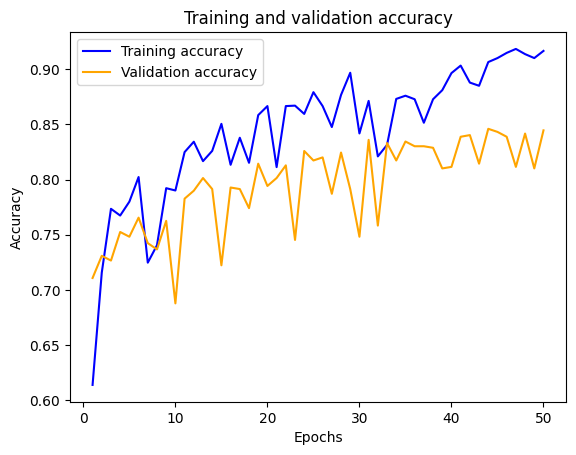

In [3]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 51)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

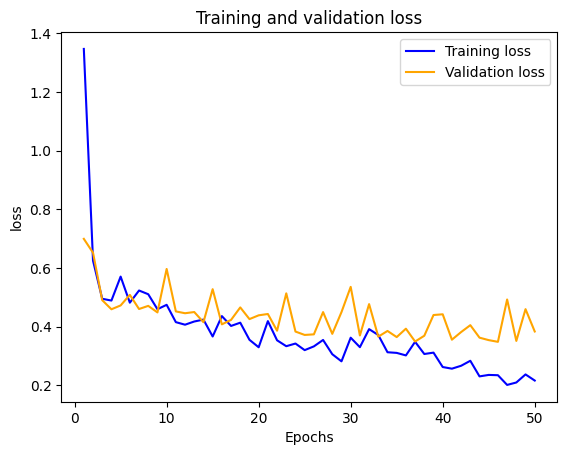

In [7]:
import matplotlib.pyplot as plt
# Plot the epoch vs accuracy curve
epochs = range(1, 51)
plt.plot(epochs, train_loss ,'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [38]:
def calculate_metrics(confusion_matrix):
    # Extract values from confusion matrix
    TP = confusion_matrix[0][0]
    FP = confusion_matrix[1][0]
    FN = confusion_matrix[0][1]
    TN = confusion_matrix[1][1]
    
    # Calculate precision
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    
    # Calculate recall (sensitivity)
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    
    # Calculate F1 score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) != 0 else 0

    # Calculate specificity
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    
    return precision, recall, f1_score, accuracy,specificity

In [40]:
cm_fused_val= [[467  ,27],[ 81 ,120]]
# Calculate metrics
val_precision, val_recall, val_f1_score, val_accuracy, val_specificity = calculate_metrics(cm_fused_val)

# Print results
print("Precision:", val_precision)
print("Recall (Sensitivity):", val_recall)
print("F1 Score:", val_f1_score)
print("Accuracy:", val_accuracy)
print("specificity:",val_specificity)

Precision: 0.8521897810218978
Recall (Sensitivity): 0.9453441295546559
F1 Score: 0.8963531669865642
Accuracy: 0.8446043165467626
specificity: 0.5970149253731343


In [42]:
cm_ecg_train= [[1966,   12],[ 235,  569]]
# Calculate metrics
train_precision, train_recall, train_f1_score, train_accuracy, train_specificity = calculate_metrics(cm_ecg_train)

# Print results
print("Precision:", train_precision)
print("Recall (Sensitivity):", train_recall)
print("F1 Score:", train_f1_score)
print("Accuracy:", train_accuracy)
print("specificity:",train_specificity)

Precision: 0.8932303498409814
Recall (Sensitivity): 0.993933265925177
F1 Score: 0.9408949509452023
Accuracy: 0.9112149532710281
specificity: 0.7077114427860697


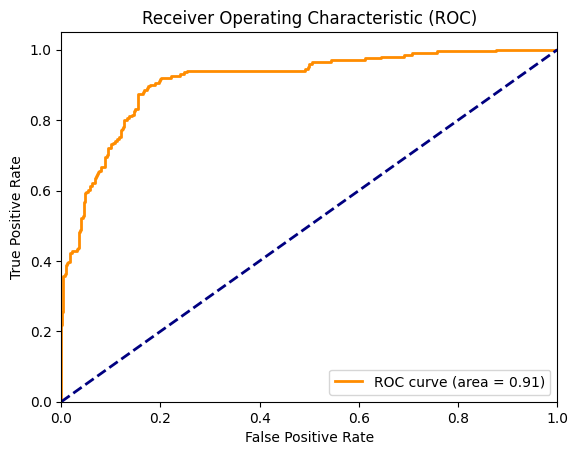

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

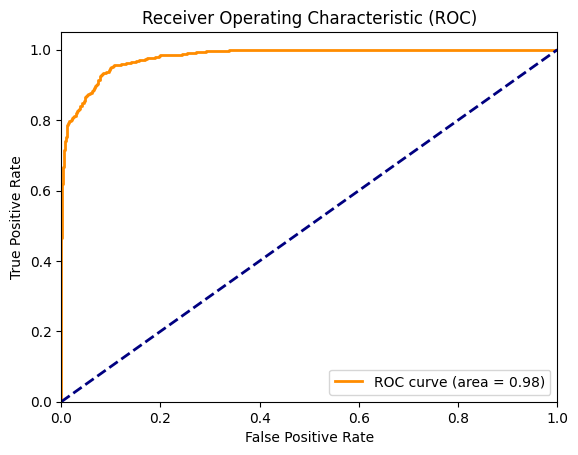

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


# Compute ROC curve and ROC area
y_true_train=train_generator.classes
fpr, tpr, thresholds = roc_curve(y_true_train, y_pred_prob_train)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

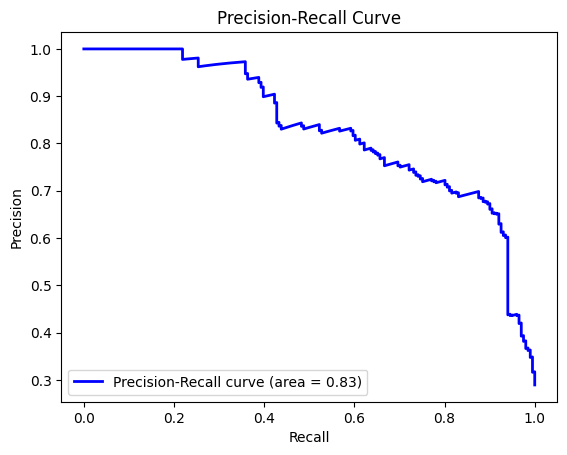

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
y_true_val=val_generator.classes
precision, recall, thresholds = precision_recall_curve(y_true_val, y_pred_prob_val)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

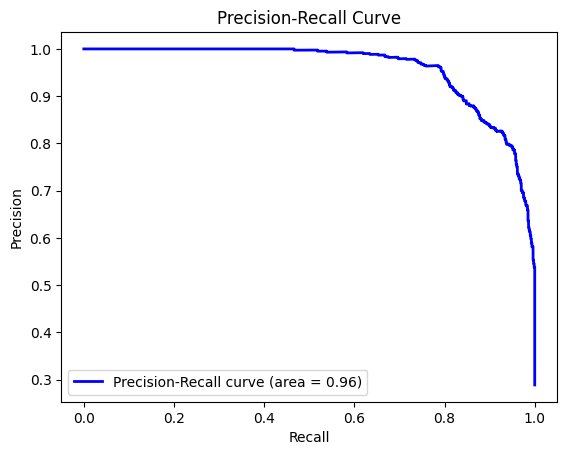

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc


# Calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_true_train, y_pred_prob_train)

# Compute area under the curve (AUC) for precision-recall curve
auc_score = auc(recall, precision)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc_score)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()